# Take a Walk on the Py side

Random and kernel walks represent fascinating techniques that have found applications in various fields, including music composition. Such stochastic processes allow for the generation of sequences where each step is a consequence of the previous step, creating coherent yet unpredictable progressions. Such methods have been embraced by composers and sound artists to wander through new territories of algorithmic and generative music, where the unpredictability and structure of these mathematical models can lead to innovative musical expressions. **Iannis Xenakis** is perhaps one of the most renowned composers to integrate stochastic processes, including random walks, into his compositions. Xenakis, a Greek-French composer and architect, utilized mathematical models to compose music that explores the interplay between order and randomness. Works like [Mikka](https://www.youtube.com/watch?v=Ifxs3TBSSAs) and [Epeï](https://www.youtube.com/watch?v=8ZP3TbLtfq4) are seminal examples where stochastic methods contribute to the structural foundation of the music. **Karlheinz Stockhausen** and his work with controlled randomness and serial techniques also touch upon concepts akin to random walks. His compositions, such as [Klavierstück XI](https://www.youtube.com/watch?v=mMDdihXI98A), employ a form of controlled chance that dictates the sequence of musical events, offering a multitude of possible paths through the piece.

The application of random walks and kernel walks in music composition involves generating sequences of musical elements, usually pitches and sequences, where each element is selected based on a combination of random choice and a set of rules or conditions influenced by previous elements. This approach allows composers to explore new forms of musical structure and texture, creating pieces that can vary greatly with each performance or realization while maintaining an underlying coherence.

## Random walks

A random walk is a mathematical process where each step is a random choice relative to the one preceeding it. Mathematician call them Markov chains, named after mathematician Andrey Markov. The random choice can be as simple as a coin flip: if it goes tail, you take a diagional step left. Heads, a diagonal step on right. Repeat the process over and over and you obtain a random walk. On average, you should walk ahead, but in fact, you'll probably derive from a straight path. The concept of randomness was introduced in [Minimalism](04_minimalism.html), but we didn't really dig in its meaning. 

### Understanding randomness

A mathematical function using a probability distribution is named a *stochastic* function. The concept of randomness is often misunderstood. It's not about everything being possible without constraints. When we talk about selecting a random number, the process is not as open-ended as it might seem. When you flip a coin, its either heads or tails (or, rarely, the edge...). 

Randomness is structured by probability distributions, a collection of mathematical functions structuring randonmess and approximate processes underlying a reality too complex to be perfectly predictable. The coin toss is a binomial distribution: it's either true or false. Another familiar example is the Normal distribution, known for its bell-shaped curve. When we sample from this distribution, values near the mean (center of the curve) are more likely to occur than those far from it, say, more than 4 units away or less than -4 units from the mean. The Normal distribution is characterized by two parameters: the mean, which locates the center of the curve, and the standard deviation, which determines the width of the curve. The height of a population can have a mean and a standard deviation.

There are numerous probability distributions, catering to different types of data. Continuous values, for instance, are often modeled using the Normal distribution, but also uniform distributions, where the likelihood of selecting any number within a specified range is exactly the same. This means that every number has an equal chance of being chosen, ensuring a flat distribution of probabilities across the entire range. Discrete data, such as categorical outcomes in music genres, can be represented by the multinomial distribution, which is described by a set of probabilities summing to 1. The Poisson distribution produces integer, useful for counting occurrences. Mathematicians have been working on probability distributions for centuries, and are still creating new ones, and exploring facinating properties of existing ones.

Understanding these distributions helps in contextualizing randomness, especially in creative domains like music, where generating random rhythms involves selecting from a defined range of possibilities according to a specific probability distribution. This structured approach to randomness allows for the generation of diverse and interesting rhythmic patterns within a coherent framework.

In [1]:
import plotly.subplots as sp
import plotly.graph_objects as go
import numpy as np
import scipy

# Normal distribution
x_norm = np.linspace(-4, 4, 100)
y_norm = scipy.stats.norm.pdf(x_norm, 0, 1)  # normal distribution with 0 mean and 1 standard deviation

# Uniform distribution
x_unif = np.linspace(-4, 4, 100)
y_unif = scipy.stats.uniform.pdf(x_unif, -1, 2) # uniform distribution from -1, spanning 2

# Multinomial distribution
n = 10
categories = ['Folk', 'Classic', 'Punk rock', 'Jazz']
p = [0.15, 0.30, 0.10, 0.45]

# Poisson distribution
mu = 3
y_poisson = scipy.stats.poisson.pmf(np.arange(10), mu)  # distribution de Poisson

# Figure
fig = sp.make_subplots(rows=1, cols=4)
fig.add_trace(go.Scatter(x=x_norm, y=y_norm, mode='lines'), row=1, col=1)
fig.update_xaxes(title_text="Normal distribution", row=1, col=1)
fig.add_trace(go.Scatter(x=x_unif, y=y_unif, mode='lines'), row=1, col=2)
fig.update_xaxes(title_text="Uniform distribution", row=1, col=2)
fig.add_trace(go.Bar(x=categories, y=p), row=1, col=3)
fig.update_xaxes(title_text="Multinomial distribution", row=1, col=3)
fig.add_trace(go.Bar(x=np.arange(10), y=y_poisson), row=1, col=4)
fig.update_xaxes(title_text="Poisson distribution", row=1, col=4)
fig.update_layout(showlegend=False, template='none')

fig.write_image("_images/probability-distributions.png")


<img src="_images/probability-distributions.png" alt="probability distributions" />

### Logic of the random walk

Random walks are available in Djalgo in file `walk.py`. From there, there are two options to generate walks. The first one, `Chain`, is a classic random walk, and the second, `Kernel`, is Gaussian processes generator, which will be discussed later in this section.

The random walk generator takes several of arguments. The `walk_range` argument takes a list of the minimum and maximum numbers to confine the walk (to create a *bounded* random walk). For instance, if you aim at restraining the walk between -10 and 10, you would enter `walk_range=[-10, 10]`. The `walk_probability` can take a list of numbers, for instance `[-1, 0, 1]` if you aim at generating steps of -1, 0 and 1. It can also take a [Scipy probability distribution](https://docs.scipy.org/doc/scipy/reference/stats.html) function, for instance `scipy.stats.norm(loc=0, scale=1)`, where `loc` and `scale` are the mean and the standard deviation. The `length` argument specifies the number of steps. The `round_to` argument, with default `None`, rounds stepping to a given decimal.

Djalgo has the hability to randomly branch a walk. When a walk is branched, a new walk is created and wanders on it own. The probability to branch is specified from 0 to 1 in the `branching_probability` argument. Conversely, `merging_probability` is the probability to merge random walks when they collide. If `round_to` is not triggered on, there is virtually no chance that branches collide.

### Example



I'd like to generate a random walk through pitches from `C2` to `C8`, starting at `C4`. MIDI pitch numbers can be recovered using Djalgo's abc_to_midi utility function.

In [2]:
import djalgo as dj
print('C2:', dj.utils.abc_to_midi('C2'))
print('C4:', dj.utils.abc_to_midi('C4'))
print('C8:', dj.utils.abc_to_midi('C8'))

C2: 36
C4: 60
C8: 108


The random walk will be conducted between numbers 36 to 108 through 20 steps, starting at 60. Through the walk, each step will branch with a probability of 0.1 and when branches goes to the same pitch, they will merge with a probability of 0.9.

In [3]:
rw = dj.walk.Chain(
    walk_range=[36, 108], walk_start=60, walk_probability=scipy.stats.norm(loc=0, scale=2),
    length=20, round_to = 0, branching_probability=0.1, merging_probability=0.9
)
rw

The `rw` is a random walk object, which can be used to generate many random walks, although only one will be generated in this example.

In [4]:
rw_sequences = rw.generate(seed=6)
len(rw_sequences)

9

`rw_sequences` contains 5 branches. If you examine the object, you will see lists begining with `None` values, which are generated when a new branch is created to make sure all branches are generated with the same length. At each step, if branching returns `True` with probability `branching_probability`, a new list is created, and the random walk becomes a list of lists, and all values of the new list happening before the branch are set to `None`. Each branch then has its own random walk, and can branch out. If two or more branch collide to the same values, and if merging if `True` according to probability `merging_probability`, lists are closed with `None` values to the following notes, except the branch with the lower index, on which the other branches are merged. The merged branch continues the random walk, and can branch again.

In [5]:
import plotly.graph_objects as go
fig = go.Figure()
for i, seq in enumerate(rw_sequences):
    fig.add_trace(go.Scatter(
        x=[i for i, val in enumerate(seq) if val is not None],
        y=[val for val in seq if val is not None],
        mode='lines'
    ))
fig.update_layout(showlegend=False)
fig.write_image("_images/chain-walk-example.png")

<img src="_images/chain-walk-example.png" alt="plot of the result of the chain-walk example">

We can map pitches to durations by creating a rhythm for each track.

In [7]:
index_quarter_length = 1.0  # Length of a quarter note in the random walk index
measure_length = 4  # Duration of each measure
rw_notes = []
rhythm_durations = [ # the same number of sets as len(rw_sequences)
    [0.125, 0.25, 0.5, 1, 2],
    [1, 2],
    [1, 2],
    [1, 1, 2],
    [0.5, 1, 2],
    [0.5, 1],
    [0.5, 0.5, 1],
    [0.25, 0.5, 1, 2],
    [0.125, 0.25, 0.5, 1, 2]
]
for seq, random_dur in zip(rw_sequences, rhythm_durations): # zip to the shortest length
    rhythm = dj.rhythm.Rhythm(measure_length=measure_length, durations=random_dur).random(seed=6)
    dur = [r[0] for r in rhythm]
    iso = dj.rhythm.isorhythm(pitches=seq, durations=dur)
    rw_notes.append(iso)
dj.conversion.to_music21(rw_notes).show('midi')

The result is on the chromatic scale. To provide a little structure to a walk, we can wander through indexes of a scale list rather that on notes.

In [60]:
g_major = dj.harmony.Scale('G', 'major').generate()[39:53]
# [dj.utils.midi_to_abc(p) for p in g_major] # used to adjust the range fro 39 to 53
rw_index = dj.walk.Chain(
    walk_range=[0, len(g_major)-1], walk_start=7, walk_probability=scipy.stats.norm(loc=0, scale=2),
    length=20, round_to = 0, branching_probability=0.1, merging_probability=0.9
).generate(seed=1)

In [63]:
measure_length = 3
rw_notes_tuned = []
for seq in rw_index:
    rhythm = dj.rhythm.Rhythm(measure_length=measure_length, durations=[0.5, 1, 2]).random(seed=1)
    d = [r[0] for r in rhythm]
    p = [g_major[int(index)] for index in seq if index is not None]
    iso = dj.rhythm.isorhythm(
        pitches=p,
        durations=d
    )
    rw_notes_tuned.append(iso)
dj.conversion.to_music21(rw_notes_tuned).show('midi')

## Gaussian processes

A normal distribution is a mathematically elegant way of describing the average and variance (diversity) among a population. We can have as many normal distributions as the amount of variables describing a population, for example age, height and weight of people in Canada. When we think that our variables are linked one another, like height, weight and age, we can stack normal distributions together in a single multivariate normal distribution. Such distribution is described by a vector of 3 means and a 3×3 covariance matrix, a squared matrix with variances on the diagonal and pairwise covariances between variables elsewhere, describing the strength of the link between variables. There is no limit on the amount of variables in the multivariate normal. For example, day after day, you measure air temperature hourly, at 7:00, 8:00, 9:00, etc. You will have one normal distribution of temperature on Mondays, one on Tuesdays, etc. Since the temperature at hours closed to each other are likely correlated, you might use a multivariate normal. And because the correlation between temperatures will slowly vanish for distant measurements, you could use a function to describe the correlation. Such function will reveal to be useful if you narrow the time steps. For instance, if you record the temperature at each second, you will have a large amount of variables, thus a long mean vector and an extended covariance matrix. To go even further, since time is continuous, our multivariate normal will contain an infinity of dimensions. A multivariate normal distribution with infinite number of dimensions is called a Gaussian process.

To allow infinite dimensions, and compute probabilities at any dimension, the mean vector and the covariance matrix must be described by functions. The mean function is usually ruled out of the equation since it can be dealt offsetting the outcome by setting it to constant zero. A Gaussian musical signal can be a wave generating numbers to add to 60, the midi number representing the center C on the keyboard of a piano. This is why Gaussian processes are mostly described by the covariance function, also called the *kernel*. Samples from a normal or a multivariate normal distribution are points. Samples from a Gaussian process, because they are continuous, are functions.

These functions can be used just as we used random walks. So why bothering with abstract mathematical concepts if you could just use a random walk function? Because Gaussian processes carry very interesting properties. You might indeed have heard of Gaussian processes as a machine learning method. They are indeed. This means that they can be fitted to data.

In this section, I will introduce you to the use of unfitted and fitted Gaussian processes to generate music.

### Music from unfitted Gaussian processes

Unfitted Gaussian processes are only described by their kernel. Random samples from a kernel will create a pattern for music to follow. As any translational music practice, many music attributes can be generated. However, I will keep my focus on notes.

In the following code block, the `RBF` class creates the covariance function, as known as the kernel, with two properties. The `length_scale` parameter describes the inertia of the covariance. Larger lengths create longer waves. The multiplier of the kernel, often refered as $\alpha$ in textbooks, describes the amplitude of the wave. The `GaussianProcessRegressor` class is instanciated for a realisation of the `RBF` kernel. The outcome is a plot showing the effect of the length and $\alpha$.

In [ ]:
lenght_scales = [0.1, 0.5, 1]
alphas = [1, 5, 10]
param_combinaisons = np.stack(np.meshgrid(lenght_scales, alphas), -1).reshape(-1, 2)

signal_length = 10
X = np.linspace(0, signal_length, 200).reshape(-1, 1)
df_samples = []
for i in range(param_combinaisons.shape[0]):
    alpha = param_combinaisons[i, 1]
    length = param_combinaisons[i, 0]
    kernel = alpha * RBF(length_scale=length)
    gp = GaussianProcessRegressor(kernel=kernel, random_state=1)
    df_samples.append(
        pd.DataFrame(dict(
            alpha=alpha,
            length=length,
            x = X.flatten(),
            y = gp.sample_y(X, 1).flatten()
        ))
    )
df_samples = pd.concat(df_samples)
px.line(df_samples, x='x', y='y', facet_col='alpha', facet_row='length')


Generate a signal, and set the units on the x-axis in quarter-notes, so that a signal length of 16 contains 4 measures in the context of a 4/4 time signature. As before, I reshape the `X` variable to transform it into a column vector. Indeed, *scikit-learn* expects X inputs as columns because it can accept many inputs, conventionnally stacked as columns in data science.

In [42]:
signal_length = 16
X = np.linspace(0, signal_length, 200).reshape(-1, 1)
gp = GaussianProcessRegressor(kernel = 10.0 * RBF(length_scale=0.5))
y_samples = 60 + gp.sample_y(X, 1) # 1 for one signal, + 60 to offset and obtain a midi note
(
    go.Figure()
    .add_trace(go.Scatter(x=X.flatten(), y=y_samples[:, 0].flatten(), mode='lines', name='Signal'))
    .update_layout(xaxis=dict(title='Time (quarter notes)'), yaxis=dict(title='Midi note'))
)

In [4]:
n_measures_in_durations = 2
qnlength = n_measures_in_durations * 4
n_cycles = n_measures / n_measures_in_durations
gp1_durations = random_beat(qnlength=qnlength, durations=[0.5, 0.5, 1, 2])
gp1_durations_iterator = itertools.cycle(gp1_durations)
gp1_times_qn = []
time_i = 0
for i in range(int(n_cycles * len(gp1_durations))):
    time_i = time_i + next(gp1_durations_iterator)
    gp1_times_qn.append(time_i)

NameError: name 'n_measures' is not defined

In [63]:
X_qn = X * 4
gp1_intervals = []
for t in gp1_times_qn:
    gp1_intervals.append(np.interp(t, X_qn.flatten(), y_samples[:, 0]))

In [64]:
(
    go.Figure()
    .add_trace(go.Scatter(x=X_qn.flatten(), y=y_samples[:, 0].flatten(), mode='lines', name='Signal'))
    .add_trace(go.Scatter(x=gp1_times_qn, y=gp1_intervals, mode='markers', name='Notes'))
    .update_layout(xaxis=dict(title='Time (measures)'), yaxis=dict(title='Interval'))
)

In [71]:
gp1_stream = walk_intervals_to_stream(
    base_note = note.Note('D3'),
    intervals = np.round(gp1_intervals),
    durations = gp1_durations,
    base_key = key.Key('C')
)
gp1_stream.show('midi')

Generating gaussian signals might look overcomplicated compared to random walks, but they can provide insightful benefits. Aat the beginning of this chapter, I wrote that gaussian processes are used as a machine learning method. That means that they can be fitted to data. This is the point of this book opening a the perspective of data sonification.

### Fitted gaussian processes

Conditionning...

When a Gaussian process is fitted on, for instance, temperature, the fundamental question you ask as the modeller is what function the temperature might have followed. A fitted Gaussian process can generate as many of such functions as you require, so you end up with a distribution of functions. 

The question can be asked similarly for a musical score: what variations be be extracted from a constrained pattern?

The `gpr` object was not fitted previously.

In [72]:
pachelbel_progression = ['C5', 'G4', 'A4', 'E4', 'F4', 'C4', 'F4', 'G4', 'C5'] # including last C5
pachelbel_progression_s = stream.Stream()
for n in pachelbel_progression:
    pachelbel_progression_s.append(note.Note(n, quarterLength=1))

In [73]:
pachelbel_progression_midi = [n.pitch.midi for n in pachelbel_progression_s]
pachelbel_progression_time = np.arange(0, 9).reshape(-1, 1)

In [74]:
pachelbel_progression_midi = np.array(pachelbel_progression_midi)
pachelbel_progression_midi_sc = (pachelbel_progression_midi - pachelbel_progression_midi.mean())/pachelbel_progression_midi.std()

In [75]:
kernel = 1.0 * RBF(length_scale=0.25, length_scale_bounds=(1e-1, 0.5))
gp_pac = GaussianProcessRegressor(kernel=kernel, random_state=0)
gp_pac.fit(pachelbel_progression_time, pachelbel_progression_midi_sc)

/Users/essi/opt/miniconda3/envs/music/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 0.5. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=0.25), random_state=0)

Text(0, 0.5, 'Note midi')

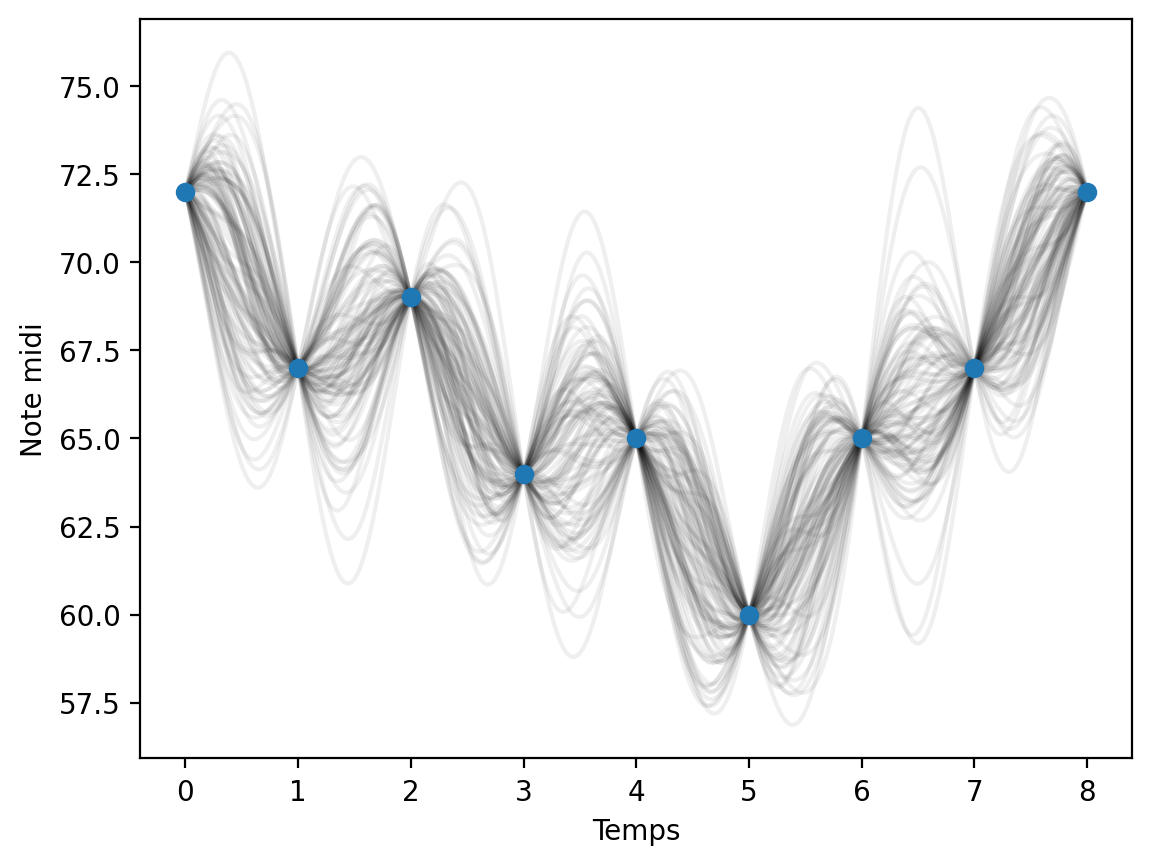

In [76]:
n_samples = 50
pred_time = np.linspace(0, 8, 300).reshape(-1, 1)
y_samples_sc = gp_pac.sample_y(pred_time, n_samples)
y_samples = y_samples_sc * pachelbel_progression_midi.std() + pachelbel_progression_midi.mean()

for i in range(n_samples):
    plt.plot(pred_time, y_samples[:, i], c='#0f0f0f10')
plt.plot(pachelbel_progression_time, pachelbel_progression_midi, 'o')
plt.xlabel('Temps')
plt.ylabel('Note midi')

Each line in this fit is a possible variation of Pachelbel's canon.

In [77]:
def gp_to_stream(qnLength, duration_, gp_xy, base_key, round_direction='up'):
    time = np.concatenate([[0], np.cumsum(duration_)])
    midi = np.interp(time, gp_xy[:, 0], gp_xy[:, 1])
    duration_ = [duration.Duration(d) for d in duration_]
    note_ = [note.Note(n.round(0)) for n in midi]
    stream_ = stream.Stream()
    for n,d in zip(note_, duration_):
        n = match_key(n, base_key, round_direction=round_direction)
        n.duration = d
        stream_.append(n)
    return(stream_)

In [78]:
track0 = stream.Stream()
for n in pachelbel_progression[:8]:
    track0.append(note.Note(n, quarterLength=1))
track0 = track0.transpose('P-8')

In [79]:
gp_xy0 = np.hstack([pred_time, y_samples[:, 0].reshape(-1, 1)])

pattern1 = [0.5, 0.5, 1, 0.5, 0.5, 1, 0.25, 0.25, 0.5, 1, 2]
pattern2 = [1, 1, 1, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 1, 1]
pattern3 = [0.5, 0.25, 0.25, 0.125, 0.125, 0.25, 0.5, 1, 1, 0.5, 0.5, 0.75, 0.25, 1, 1]
pattern4 = copy.copy(pattern2)
random.shuffle(pattern2)
pattern5 = [0.5, 0.25, 0.25, 1] * 4
pattern6 = [0.5]*16

pac_durations = [pattern1, pattern2, pattern3, pattern4, pattern5, pattern6]

gp_streams = [track0]

for d in pac_durations:
    gp_s = gp_to_stream(
        qnLength=8,
        duration_=d,
        gp_xy=np.hstack([pred_time, y_samples[:, random.choice(range(n_samples))].reshape(-1, 1)]),
        base_key=key.Key('C'),
        round_direction=None
    )
    gp_streams.append(gp_s)

In [80]:
for i,s in enumerate(gp_streams):
    s.write('midi', 'track'+str(i)+'.midi')


# More complex walks with Gaussian processes

In [ ]:
import pretty_midi
import djalgo as dj
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ExpSineSquared

In [ ]:
# Charger le fichier MIDI
midi_data = pretty_midi.PrettyMIDI('data/movies/TV_Themes_-_Addams_Family.mid')

# Obtenir les changements de tempo
tempo_changes_times, tempos = midi_data.get_tempo_changes()
bpm = tempos.mean()
bps = bpm / 60
instrument = midi_data.instruments[0]

pitches = []
note_start_beats = []
note_end_beats = []
note_durations = []

for note in instrument.notes:
    pitches.append(note.pitch)
    start_beat = note.start * bps
    end_beat = note.end * bps
    note_start_beats.append(start_beat)
    note_end_beats.append(end_beat)
    note_durations.append(end_beat - start_beat)
    

In [ ]:
XY = np.column_stack([note_start_beats, pitches, note_durations])

In [ ]:
num_samples = np.round(0.3 * XY.shape[0]).astype(int)
row_indices = np.random.choice(XY.shape[0], size=num_samples, replace=False)
XYsub = XY[row_indices, :]

## Model pitches

Text(0, 0.5, 'Pitch (MIDI note number)')

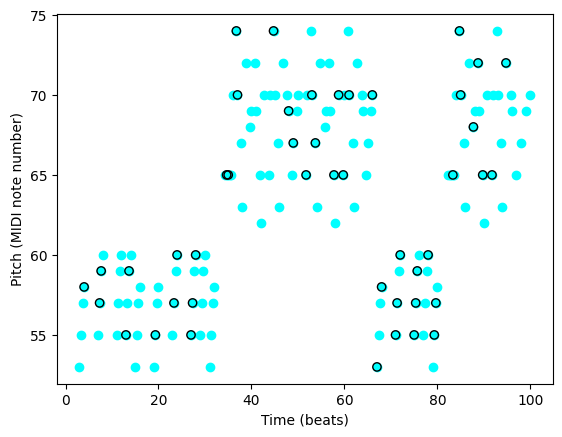

In [ ]:
plt.scatter(XY[:, 0], XY[:, 1], color='cyan')
plt.scatter(XYsub[:, 0], XYsub[:, 1], marker='o', edgecolors='black', facecolors='none')
plt.xlabel('Time (beats)')
plt.ylabel('Pitch (MIDI note number)')

In [ ]:
pitch_kernel = (
    Matern(length_scale=0.1, length_scale_bounds=(0.01, 200))
    * (ExpSineSquared(periodicity=12) + ExpSineSquared(periodicity=60))
)
pitch_gp = GaussianProcessRegressor(
    kernel=pitch_kernel,
    random_state=123,
    alpha=0.5,
    normalize_y=True
)
pitch_gp.fit(XYsub[:, 0].reshape(-1, 1), XYsub[:, 1])

GaussianProcessRegressor(alpha=0.5,
                         kernel=Matern(length_scale=0.1, nu=1.5) * ExpSineSquared(length_scale=1, periodicity=12) + ExpSineSquared(length_scale=1, periodicity=60),
                         normalize_y=True, random_state=123)

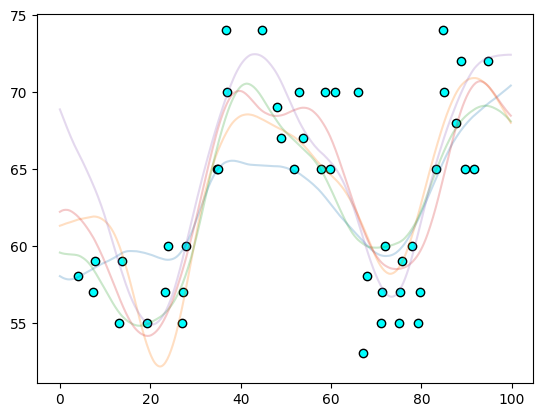

In [ ]:
beat_to_predict = np.arange(0, 100, 0.2).reshape(-1, 1)
pitch_pred = pitch_gp.sample_y(beat_to_predict, n_samples=5)
plt.plot(beat_to_predict, pitch_pred, alpha=0.25)
plt.scatter(XYsub[:, 0], XYsub[:, 1], marker='o', edgecolors='black', facecolors='cyan')

## Model durations

Text(0, 0.5, 'Duration (beats)')

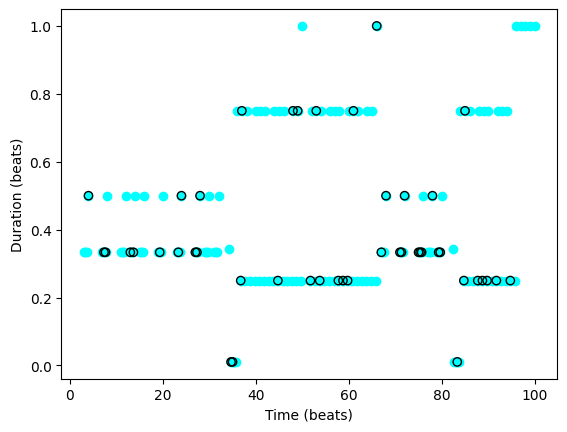

In [ ]:
plt.scatter(XY[:, 0], XY[:, 2], color='cyan')
plt.scatter(XYsub[:, 0], XYsub[:, 2], marker='o', edgecolors='black', facecolors='none')
plt.xlabel('Time (beats)')
plt.ylabel('Duration (beats)')

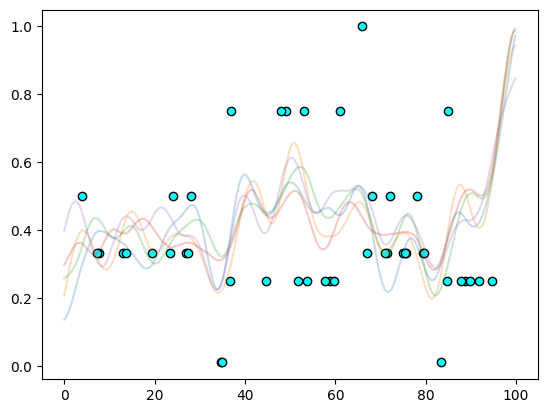

In [ ]:
duration_kernel = Matern(length_scale=50, length_scale_bounds=(10, 100)) * ExpSineSquared(periodicity=35)
duration_gp = GaussianProcessRegressor(kernel=duration_kernel, random_state=123, alpha=0.25, normalize_y=True)
duration_gp.fit(XY[:, 0].reshape(-1, 1), XY[:, 2])
duration_pred = duration_gp.sample_y(beat_to_predict, n_samples=5)
plt.plot(beat_to_predict, duration_pred, alpha=0.25)
plt.scatter(XYsub[:, 0], XYsub[:, 2], marker='o', edgecolors='black', facecolors='cyan')

# Predict

We modeled pitches and durations through time with Gaussian processes. The resulting signals is are continuous over time. We thus have to choose the start time, i.e. *where* to obtain predictions. A natural option is to select the start times of our data. Another one would be... well anything else, from writing our own beat to generate is randomly with `djalgo.rhythm.Rhythm.random()`. Let's take the original starting times.

In [ ]:
beat_to_predict = XY[:, 0].reshape(-1, 1)
pitch_pred = pitch_gp.sample_y(beat_to_predict, n_samples=2)
duration_pred = duration_gp.sample_y(beat_to_predict, n_samples=2)

I generated two samples, which will be recorded as two instruments.

In [ ]:
instrument0_array = np.column_stack([
    beat_to_predict, pitch_pred[:, 0], duration_pred[:, 0]
])
instrument1_array = np.column_stack([
    beat_to_predict, pitch_pred[:, 1], duration_pred[:, 1]
])

Pitches can be altered to comply to a given scale.

In [ ]:
full_Dminor = dj.signal.Scale(tonic='D', scale_type='minor').generate()
instrument0_array[:, 1] = [dj.utils.round_to_list(p, full_Dminor) for p in instrument0_array[:, 1]]
instrument1_array[:, 1] = [dj.utils.round_to_list(p, full_Dminor) for p in instrument1_array[:, 1]]

As well as durations

In [ ]:
allowed_durations = [1/4, 1/3, 1/2, 3/4, 1]
instrument0_array[:, 2] = [dj.utils.round_to_list(d, allowed_durations) for d in instrument0_array[:, 2]]
instrument1_array[:, 2] = [dj.utils.round_to_list(d, allowed_durations) for d in instrument1_array[:, 2]]

In [ ]:
midi_tracks = pretty_midi.PrettyMIDI()
midi_tracks.instruments.append(pretty_midi.Instrument(program=0))
midi_tracks.instruments.append(pretty_midi.Instrument(program=0))

for i in range(instrument0_array.shape[0]):
    note0 = pretty_midi.Note(
        velocity=100,
        pitch=int(instrument0_array[i, 1]),
        start=instrument0_array[i, 0],
        end=instrument0_array[i, 0] + instrument0_array[i, 2]
    )
    midi_tracks.instruments[0].notes.append(note0)
    note1 = pretty_midi.Note(
        velocity=100,
        pitch=int(instrument1_array[i, 1]),
        start=instrument1_array[i, 0],
        end=instrument1_array[i, 0] + instrument1_array[i, 2]
    )
    midi_tracks.instruments[1].notes.append(note1)
midi_tracks.write('gp_midi.mid')

## Data sonification

Range, models